In [1]:

!pwd
!python --version
import pandas as pd

import numpy as np

import warnings
#import sklearn.exceptions
#warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

#from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
#import time

import seaborn as sns
import statsmodels.api as sm
import pylab as py


from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import scipy as sp 
import confidence_interval_estimator_ML.utils as cie


/home/eitancho/Escritorio/Metodos/metnum-labo/TP3/notebooks
Python 3.8.0


/home/eitancho/.pyenv/versions/3.8.0/envs/tp2_3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/eitancho/.pyenv/versions/3.8.0/envs/tp2_3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/eitancho/.pyenv/versions/3.8.0/envs/tp2_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Funciones que vamos a necesitar


In [2]:
# Armamos la matriz X a usar

def makeMatrixXy(df):
    # x_1 = radiation, x_2 = temperature, x_3 = wind
    if df.shape[1] == 2:
        X = df.values[:,1].reshape(-1,1)
        y = df.values[:,0].reshape(-1,1)
    else:    
        X = df[df.columns[-3:]].values
        y = df["ozone"].values.reshape(-1,1)
    return (X,y)

# Esta funcion estandariza un vector.
def standarize(x, retornarStandarizacion = False , conMu = False):
    sigma = np.std(X)
    return (X/sigma , sigma)


# Aplicar a X ajuste lineal o cuadratico como la función g
## Esta funcion devuelve los coeficiontes de una funcion polinomica del estilo
# en el caso cuadratico
# [1, X_1, X_2, X_3, X_1^2, X_1X_2, X_1X_3, X_2^2, X_2X_3, X_3^2]
# en el caso lineal
# [1, x_1, X_2 , X_3]
# PD: Asi quedarían las filas de la matriz X transformada. 

def ajustarFuncionG(X, grado):
    # Aplicar ajuste
    poly = PolynomialFeatures(grado)
    X = poly.fit_transform(X)
    return X

def w(dist, maxDist, p):    
    u =  dist/maxDist
    u = np.abs(u)
    if u >= 1 :
        return 0 
    return (1-u**p)**p

def armarW(X,  pivote, f, p):
    n = X.shape[0]
    q = int(f * n)
    x = pivote
    vectorDist = np.linalg.norm(X-pivote, axis=1)
    ind = np.argsort(vectorDist)
    # Busco la distancia q-esima
    i = ind[q-1]
    maxDist = vectorDist[i]
    #Aplico la funcion w_i(x) 
    for i in range(0, vectorDist.shape[0]):
        vectorDist[i] = w(vectorDist[i], maxDist, p)    
    W = np.diag(vectorDist)
    return  W

def reslverPorSVD(A, b):
    U, s, V_t = np.linalg.svd(A)
    m = A.shape[0]
    n = A.shape[1]
    r = s.size
    # || U.T A - U.T b||
    s_inv = np.diag(np.concatenate((s, np.zeros(m - r))))
    s_inv = np.linalg.pinv(s_inv) 
    y_sol = np.matmul(U.transpose(), b)
    y_sol = np.matmul(s_inv, y_sol)
    
    if (m > n):
        y_sol = np.delete(y_sol, np.arange(n, m))
    return np.matmul(V_t.transpose(), y_sol)
    




In [5]:
def predict(x,X,y,f,g, p, beta = False):
    W = armarW(X,x,f,p)
    A = ajustarFuncionG(X, g)
    x = ajustarFuncionG(x.reshape(1,-1),g)[0]
    B = np.linalg.pinv(A.T @ W @ A) @ A.T @ W @ y
    ŷ_i = B.T @ x 
    if beta:
        return B 
    return ŷ_i 

    

In [6]:
# Aca es estandarizando
def estimate_conditioning2(X,y,x_fijos,f,p,g,std, beta = False):
    Xsd = []
    Xs = []
    for j in range(X.shape[1]):
        Xsd.append(np.std(X[:,j]))
        Xs.append(X[:,j]/Xsd[j])
    Xs = np.array(Xs).T
    y_sd =np.std(y)
    ys = y/y_sd
    res = []
    for row in x_fijos:
        if row.size == 1:
            row = row/Xsd[0]
            res.append(predict(row,Xs,ys,f,g,p)* y_sd)
        else:    
            for i in range(row.size):
                row[i] = row[i]/Xsd[i]
                res.append(predict(row,Xs,ys,f,g,p)* y_sd)
    return res
    

In [6]:
# Aca no estandarizamos
def estimate_conditioning(X,y,x_fijos,f, p, g, std):
    res = []
    for row in x_fijos:
        res.append(predict(row,X,y,f,g,p))
    return res


# Descargamos el dataset

In [8]:
df = pd.read_csv("../data/dataset.csv")


## Generamos Data sintetica

In [ ]:

def data_sintetica():

    colX = np.random.uniform(0,3 * 3.14, 111)
    colY = np.random.normal(0, 0.3, 111) + np.sin(colX)
    data = np.column_stack((colY, colX))
    return pd.DataFrame(data, columns= ["sen(x)", "x"])
df_sintetica = data_sintetica()


## Grafico para explicar la distribucion de datos 

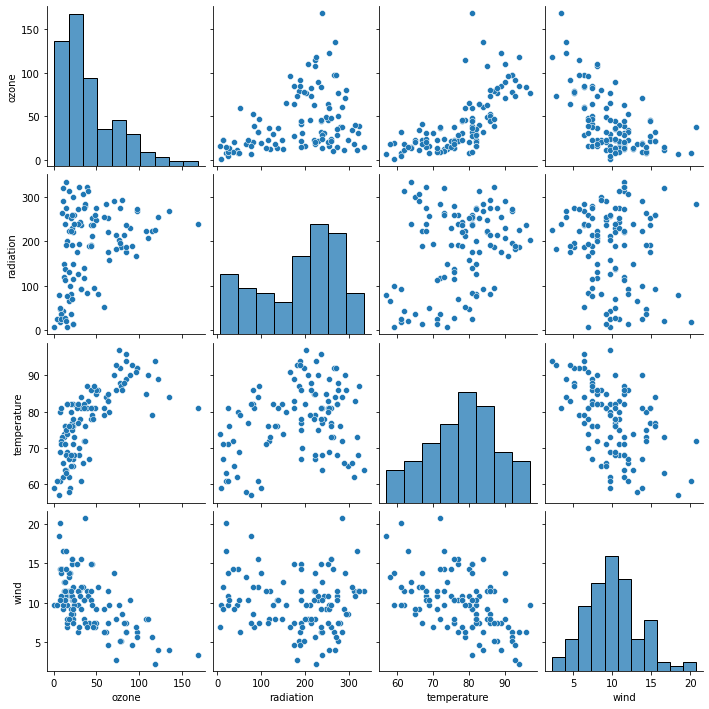

In [10]:
sns.pairplot(df[df.columns[-4:]])

## Replicamos los graficos del articulo del 88

# Component-residual Plot

In [11]:
# Comoponente \in { 1 : "radiation", 2 : "temperature", 3 : "wind"}
def component_residualplot(X, residual, componente): 
    comp = {1: "radiation", 2: "temperature", 3: "wind", 4: "x"}
    if componente == 4:
        component = X.reshape(-1,1)
        data = np.concatenate((component, residual), 1)    
    else:
        component = X[:, componente -1].reshape(-1,1)
        data = np.concatenate((component, residual), 1)
    wide_df = pd.DataFrame(data, columns = [comp[componente], "residuals"])
    grid = sns.JointGrid(x = comp[componente], y = "residuals", data= wide_df, space=0, size=6, ratio=50)
    # Create your scatter plot
    grid.plot_joint(plt.scatter, edgecolors = "k", facecolors = 'none')
    # Create your line plot.
    x =  np.linspace(np.min(component), np.max(component) + 1,200)
    ŷ_line = estimate_conditioning2(component,residual,x,f=2/3,p=3,g=1,std= True)
    grid.ax_joint.plot(x,ŷ_line, 'black', linewidth = 2)
    


## QQplot + residual abs

In [12]:

#grado = 1
#f = 3/4
def qqplot(residual):
    fig, ax = plt.subplots(figsize=(5, 5))
    residual = np.sort(residual.reshape(-1)) 
    sm.qqplot(residual, loc=np.mean(residual), scale= 1, ax = ax, markerfacecolor='none', markeredgecolor='k')
    plt.show()


def res_vs_fitted(ŷ, residual): 
    residual = np.abs(residual)
    data=np.column_stack((ŷ,np.abs(residual)))
    wide_df = pd.DataFrame(data, columns = ["fitted values", "absolute residuals"])
    grid = sns.JointGrid(x = "fitted values", y = "absolute residuals", data= wide_df)
    # Create your scatter plot
    grid.plot_joint(plt.scatter, edgecolors='k', facecolors = 'none')
    # Create your line plot.
    x =  np.linspace(np.min(ŷ), np.max(ŷ) + 1,200)
    ŷ_line = estimate_conditioning2(np.array(ŷ),residual,x.reshape(-1,1),f=2/3,p=3,g=1,std= True)
    grid.ax_joint.plot(x,ŷ_line, 'black', linewidth = 2)
    
    

In [14]:
X, y = makeMatrixXy(df)
ŷ = estimate_conditioning(X,y,X,f=0.4,p=3,g=1,std= True)
#ŷ = np.power(estimate_conditioning2(X,ys,X,f=0.8,p=3,g=2,std= True), 3)
residual = y - np.array(ŷ)

In [ ]:
qqplot(residual)
res_vs_fitted(ŷ,residual)
component_residualplot(X, residual, 2)

## plots


In [1]:
def conditioning(df, std):
    #dejo fijo 2 variables y grafico Y contra la otra

    x_solar = np.linspace(0,300,100)
    x_temperature = np.linspace(60,95,100)
    x_wind = np.linspace(3,18,100)

    fixed_solar = [290,170,50]
    fixed_temperature = [90,76,62]
    fixed_wind = [5,10,15]

    fig, axs1 = plt.subplots(3,3, constrained_layout=False)
    fig.set_size_inches(7, 7)
    plt.suptitle("Wind speed", size = 15)
    fig, axs2 = plt.subplots(3,3, constrained_layout=False)
    fig.set_size_inches(7, 7)
    plt.suptitle("Wind speed", size = 15)
    fig, axs3 = plt.subplots(3,3, constrained_layout=False)
    fig.set_size_inches(7, 7)
    plt.suptitle("Temperature", size = 15)
 
    Xs, ys = makeMatrixXy(df)
    ys = np.power(ys, 1/3)
    
    for idx,wind in enumerate(fixed_wind):
        for idj,temp in enumerate(fixed_temperature):
            x_fijos = np.column_stack((x_solar,np.full(x_solar.size,temp),np.full(x_solar.size,wind)))
            ŷ = estimate_conditioning2(Xs, ys, x_fijos ,g=2,f=.8,p=3,std= std )
            if idj != 0:
                axs1[idx,idj].axes.yaxis.set_visible(False)
            if idx != 2:
                axs1[idx,idj].axes.xaxis.set_visible(False)
            axs1[idj,idx].set_ylim(0, 7)
            axs1[idj,idx].plot(x_solar,ŷ, "k")
    for idx,wind in enumerate(fixed_wind):
        axs1[0,idx].set_title(wind)
    axs1[2,1].set_xlabel("Solar Radiation", size=15)
    axs1[1,0].set_ylabel("Cube Root Ozone", size=15)
    par = axs1[1,2].twinx()
    par.set_yticklabels([])
    par.set_ylabel("Temperature", size = 15)
    for idx,temp in enumerate(fixed_temperature):
        axs1[idx,2].set_title(temp,loc='right')

    for idx,wind in enumerate(fixed_wind):
        for idj,solar in enumerate(fixed_solar):
            x_fijos = np.column_stack((np.full(x_temperature.size,solar),x_temperature ,np.full(x_temperature.size,wind)))
            ŷ = estimate_conditioning2(Xs, ys, x_fijos ,g=2,f=.8,p=3,std= std )
            axs2[idj,idx].set_ylim(0, 7)
            axs2[idj,idx].plot(x_temperature,ŷ, "k")
            if idj != 0:
                axs2[idx,idj].axes.yaxis.set_visible(False)
            if idx != 2:
                axs2[idx,idj].axes.xaxis.set_visible(False)
    axs2[2,1].set_xlabel("Temperature", size=15)
    axs2[1,0].set_ylabel("Cube Root Ozone", size=15)
    par = axs2[1,2].twinx()
    par.set_yticklabels([])
    par.set_ylabel("Solar Radiation", size = 15)
    for idx,wind in enumerate(fixed_wind):
        axs2[0,idx].set_title(wind)

    for idx,solar in enumerate(fixed_solar):
        axs2[idx,2].set_title(solar,loc='right')

    for idx,temp in enumerate(fixed_temperature):
        for idj,solar in enumerate(fixed_solar):
            x_fijos = np.column_stack((np.full(x_wind.size,solar),np.full(x_wind.size,temp),x_wind))
            ŷ = estimate_conditioning2(Xs, ys, x_fijos ,g=2,f=.8,p=3,std= std )
            axs3[idx,idj].set_ylim(0, 7)
            axs3[idx,idj].plot(x_wind,ŷ, "k")
            if idj != 0:
                axs3[idx,idj].axes.yaxis.set_visible(False)
            if idx != 2:
                axs3[idx,idj].axes.xaxis.set_visible(False)
    axs3[2,1].set_xlabel("Wind Speed", size=15)
    axs3[1,0].set_ylabel("Cube Root Ozone", size=15)
    par = axs3[1,2].twinx()
    par.set_yticklabels([])
    par.set_ylabel("Solar Radiation", size = 15)    
    for idx,temp in enumerate(np.flip(fixed_temperature)):
        axs3[0,idx].set_title(temp)

        axs1[idx,2].set_ylabel(temp)
    for idx,wind in enumerate(fixed_wind):
        axs3[idx,2].set_title(wind,loc='right')
    
  

In [ ]:
conditioning(df, True)

## Variar funcion de Distancia

In [20]:
def distFunction (x, p):
    x= np.abs(x)
    if x >= 1 :
        return 0 
    return (1-x**p)**p

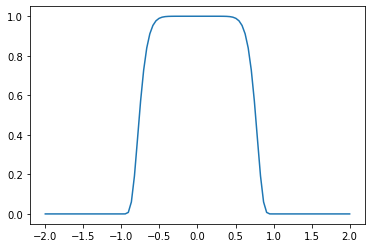

In [21]:
plt.plot(np.linspace(-2,2,100), [distFunction(x,10) for x in np.linspace(-2,2,100)])

# Experimentos

In [3]:
def graph_estimator(x,X, y, ŷ, semirect = False, graficarFuncion =True):
    plt.scatter(X, y, edgecolors = "#6b1528", facecolors = "none")
    plt.plot(x, ŷ, color = "black", linewidth=2, label = "Regresión")
    df = data_sintetica()
    if graficarFuncion:
        plt.plot(np.linspace(0,10),np.sin(np.linspace(0,10)), color = "green", label = "Función", linewidth = 2.0)
    plt.legend()
    #plt.xlabel("x")
    #plt.ylabel("ŷ")
    #plt.title("Regresión de la función")
    plt.show()
    

# Variamos f, g, p al graficar la regresión del sen(x)

Vemos las posibilidades de la data sintetica variando a y b y la varianza de los datos de la función 
$sen(x)$

In [ ]:
X , y = makeMatrixXy(df_sintetica)
ŷ = estimate_conditioning2(X,y,X,f=0.5,p=3,g=9,std=True)
residual_s = y - ŷ

In [109]:
x = np.linspace(0, 10,300)
sên_x = estimate_conditioning2(X,y,x,f=0.9,p=3,g=3,std=True)


In [ ]:
graph_estimator(x,X, y,sên_x, graficarFuncion=False)


In [ ]:
component_residualplot(X,residual_s,4)
res_vs_fitted(ŷ, residual_s)